In [2]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import torch
import torch.nn as nn
from tqdm import tqdm

import seaborn as sns
import matplotlib.pyplot as plt


In [3]:
dataset = pd.read_csv('dataset/dataset_labelled.tsv', sep='\t')

In [4]:
def age_analyse(x):
    x = np.array(x[1:-1].split(', ')).astype('int')
    x_min = x.min()
    x_max = x.max()
    x_std = x.std()

    return pd.Series([x_min, x_max, x_std])

dataset[['age_min', 'age_max', 'age_std']] = dataset['people_age'].apply(age_analyse)

In [5]:
dataset.drop(['people_age', 'time_arrival'], inplace=True, axis=1)

In [6]:
dataset

,people_num,children,budget,nights,spa,pool,pet_friendly,lakes,mountains,sport,...,family_rating,outdoor_rating,food_rating,leisure_rating,service_rating,user_score,label,age_min,age_max,age_std
0,3,False,138.798883,1,True,True,False,True,True,True,...,1.341722,1.977943,3.904595,2.760953,1.316275,0.615780,0.0,18.0,24.0,2.624669
1,3,True,138.798883,1,False,False,False,True,True,False,...,2.891142,1.937565,5.511516,0.081772,4.375542,3.902291,0.0,18.0,24.0,2.624669
2,3,False,138.798883,1,True,True,False,True,True,True,...,0.135038,0.943798,2.814335,1.348137,4.233355,1.995977,0.0,18.0,24.0,2.624669
3,3,False,138.798883,1,True,True,False,True,True,False,...,0.797574,1.716623,4.799925,3.574869,0.862926,1.873151,0.0,18.0,24.0,2.624669
4,3,True,138.798883,1,True,False,False,True,True,True,...,2.776166,1.409502,3.763358,1.729342,4.480145,4.818102,0.0,18.0,24.0,2.624669
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,2,True,534.735442,3,True,True,False,True,False,False,...,2.294961,2.450650,4.951045,1.798212,2.774078,2.540988,0.0,23.0,36.0,6.500000
9996,2,False,534.735442,3,True,True,False,True,False,False,...,3.148868,3.886043,5.120518,2.991340,0.885180,4.367160,1.0,23.0,36.0,6.500000
9997,2,True,534.735442,3,True,True,False,True,False,False,...,1.481143,4.725230,0.824057,1.549270,1.549634,2.205281,0.0,23.0,36.0,6.500000
9998,2,False,534.735442,3,True,True,False,True,False,False,...,2.528645,1.212675,5.541728,3.560059,4.038352,3.480947,0.0,23.0,36.0,6.500000


In [7]:
X = dataset.drop('label', axis=1).values
Y = dataset['label'].values

In [8]:
X.shape, Y.shape

((10000, 26), (10000,))

In [9]:
X_tr, X_ts, Y_tr, Y_ts = train_test_split(X, Y, test_size=0.2, random_state=42)
Y_tr = Y_tr.reshape(-1, 1)
Y_ts = Y_ts.reshape(-1, 1)

In [10]:
X_tr.shape, Y_tr.shape, X_ts.shape, Y_ts.shape

((8000, 26), (8000, 1), (2000, 26), (2000, 1))

In [11]:
Y_tr.mean(), Y_ts.mean()

(0.091625, 0.095)

In [12]:
mms = MinMaxScaler()
X_tr = mms.fit_transform(X_tr)
X_ts = mms.transform(X_ts)

<AxesSubplot:>

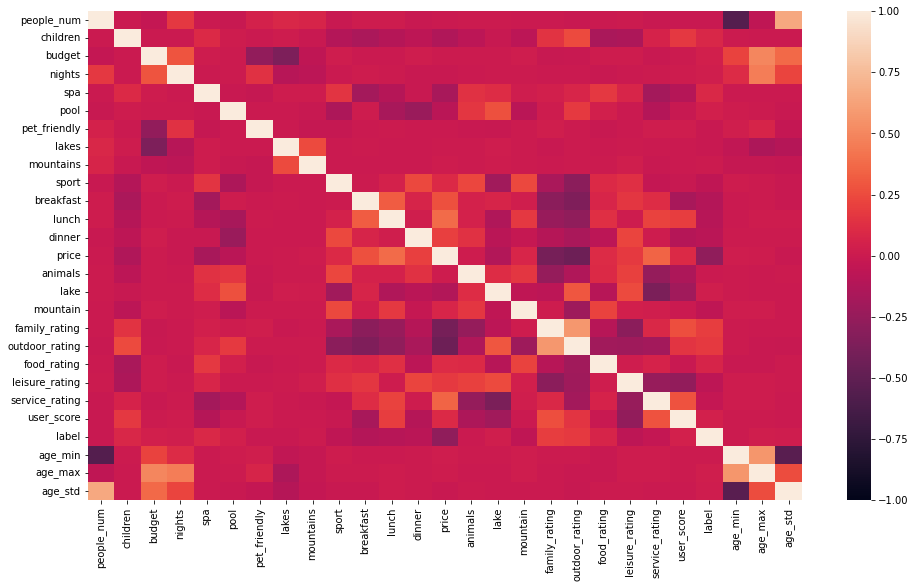

In [19]:
plt.figure(figsize=(16,9))
sns.heatmap(dataset.corr(method='spearman'), vmin=-1.0, vmax=1.0)

In [26]:
class Model(nn.Module):

    def __init__(self):
        super(Model, self).__init__()
        
        self.layers = [
            nn.Linear(26, 64),
            nn.ReLU(),
            nn.Linear(64, 16),
            nn.ReLU(),
            nn.Linear(16, 1),
            nn.Sigmoid(),
        ]

        self.net = nn.Sequential(*self.layers)

    def forward(self, x):
        return self.net(x)


In [30]:
epochs = 20
batch_size = 8
n, _ = X_tr.shape
batch_count = int(n / batch_size)

frac1 = 0.5

model = Model().to('cpu')

optimizer = torch.optim.Adam(model.parameters())

r = np.random.default_rng(42)

criterion = nn.BCELoss()

history_loss = []

for epoch in range(epochs):
    model.train()

    t =  tqdm(range(batch_count))
    for batch in t:
        mask = (Y_tr == 0).reshape(-1)

        X_tr_0 = X_tr[mask]
        X_tr_1 = X_tr[~mask]

        Y_tr_0 = Y_tr[mask]
        Y_tr_1 = Y_tr[~mask]

        n0, _ = X_tr_0.shape
        n1, _ = X_tr_1.shape

        sample_ids_0 = r.choice(n0, size=min(n, int(batch_size * (1 - frac1))))
        sample_ids_1 = r.choice(n1, size=min(n, int(batch_size * frac1)))

        X_tr_sel = np.vstack((X_tr_0[sample_ids_0], X_tr_1[sample_ids_1]))
        Y_tr_sel = np.vstack((Y_tr_0[sample_ids_0], Y_tr_1[sample_ids_1]))

        x = torch.FloatTensor(X_tr_sel).to('cpu')
        y = torch.FloatTensor(Y_tr_sel).to('cpu')

        out = model(x)

        loss = criterion(out, y)
        l_val = loss.item()
        history_loss.append(l_val)

        t.set_postfix(Loss=l_val, Epoch=f'{epoch:3}', Batch=f'{batch:3}')
        t.update()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


100%|██████████| 1000/1000 [00:02<00:00, 394.13it/s, Batch=999, Epoch=19, Loss=0.77] 


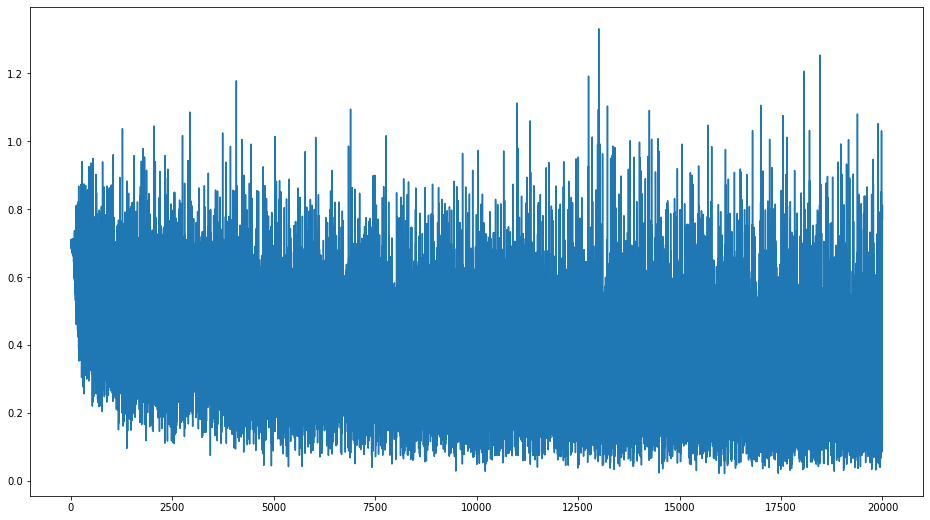

In [35]:
plt.figure(figsize=(16,9))
plt.plot(history_loss)